# Filtered regression obs 1979-2014

# I think we'll use 8 year high and low pass filters. Should mean ENSO is high freq but everything longer is low freq.

# Should we just be filtering temperature and not sea ice? Don't think so.

### NEXT DO GLOBAL AND REGRESSING MONTHS 1-9 ON SEPT SIE. ALSO DIFFERENT MODELS.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as stats 
import os as os
import warnings
import matplotlib.pyplot as plt

from IPython.display import clear_output
from scipy import signal

In [2]:
import preprocess_utils as pputils
import analysis_utils as autils 

## Load observational data (need to update with three different versions of sea ice sat data): 

In [3]:
all_months = [1,2,3,4,5,6,7,8,9,10,11,12]
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec','Annual']

#### t2m: 

In [4]:
era_path = '/glade/work/rclancy/monthly_tas_ERA5.nc'
era_data = xr.load_dataset(era_path)
era_data = pputils.rename_lat_lon(era_data)
era_data = pputils.rename_dimensions(era_data, '')

In [5]:
# Selecting just 40years from 1979 to 2014
era_data = era_data.sel(time=slice("1979-01-01", "2014-12-31"))

In [6]:
era_data['t2m_arc_mean'] = autils.calc_arctic_mean(era_data.t2m.isel(expver=0), 60)
era_data['t2m_arc_mean_climo'] = era_data.t2m_arc_mean.groupby('time.month').mean()
era_data['t2m_arc_mean_anom'] = era_data.t2m_arc_mean.groupby('time.month') - era_data['t2m_arc_mean_climo']

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


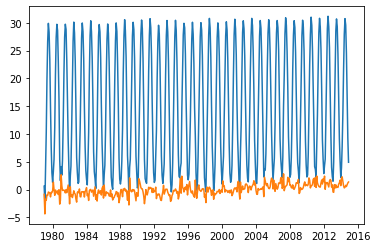

In [7]:
# Check annual cycle and monthly anoms look good.
plt.plot(era_data.time, era_data['t2m_arc_mean'] - 250)
plt.plot(era_data.time, era_data['t2m_arc_mean_anom'])

In [8]:
era_data['t2m_arc_mean_annual'] = era_data.t2m_arc_mean.groupby('time.year').mean()
era_data['t2m_arc_mean_annual_anom'] = era_data.t2m_arc_mean_annual - era_data.t2m_arc_mean_annual.mean(dim='year')

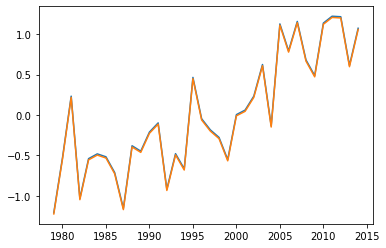

In [9]:
# Check annual anoms look good.
plt.plot(era_data.year, era_data['t2m_arc_mean_annual'] - 265)
plt.plot(era_data.year, era_data['t2m_arc_mean_annual_anom'])

In [10]:
# Butterworth filter functions

def butter_filt(x, filt_year, fs, order_butter, ftype):
    #filt_year = 1 #1 year
    #fs = 12 #monthly data
    # if ftype = band provide filt_year as a list or np array
    #fn = fs/2; # Nyquist Frequency
    fc = (1 / np.array(filt_year)) / 2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    #fc = (1/2)/2 # cut off frequency 1sample/ 2year = (1/1)/2 equals 2 year filter (two half cycles/sample)
    #fc = (1/4)/2 # cut off frequency 1sample/ 4year = (1/1)/2 equals 4 year filter (two half cycles/sample)
    #ftype = "low", "high" or "band"
    b, a = signal.butter(order_butter, fc, ftype, fs=fs, output='ba')

    return signal.filtfilt(b, a, x)

def filtfilt_butter(x, filt_year, fs, order_butter, ftype, dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function    
    filt = xr.apply_ufunc(
                butter_filt,  # first the function
                x,# now arguments in the order expected by 'butter_filt'
                filt_year,  # as above
                fs,  # as above
                order_butter,  # as above
                ftype,
                input_core_dims=[[dim], [], [], [], []],  # list with one entry per arg
                output_core_dims=[[dim]],  # returned data has 3 dimension
                exclude_dims=set((dim,)),  # dimensions allowed to change size. Must be a set!
                vectorize=True,  # loop over non-core dims
                )

    return filt

def filtfilt_butter_monthly(x, filt_year, fs, order_butter, ftype, dim='time'):
    """
    Use this to filter each month of a timeseries separately and combine
    
    in:
    x = unfiltered vector time series e.g.: era_data['t2m_arc_mean_anom']
    others as for filtfilt_butter
    
    out:
    temp = filtered output
    """
    temp = np.zeros_like(x) * np.nan
    for m in range(0, 12):
        temp[m : len(temp) : 12] = filtfilt_butter(x.sel(time=x.time.dt.month == m+1),
                                                  filt_year=filt_year, fs=fs, order_butter=order_butter,
                                                  ftype=ftype, dim=dim)
    temp = xr.DataArray(temp, coords={'time': x.time}, dims=['time'])
    return temp

In [11]:
# Choosing 8 years for cutoff as this should keep ENSO as interannual variability

# Monthly
era_data['t2m_arc_mean_anom_low_8'] = filtfilt_butter_monthly(era_data['t2m_arc_mean_anom'],
                                                            filt_year=8, fs=1, order_butter=5,
                                                            ftype='low', dim='time')

era_data['t2m_arc_mean_anom_high_8'] = filtfilt_butter_monthly(era_data['t2m_arc_mean_anom'],
                                                            filt_year=8, fs=1, order_butter=5,
                                                            ftype='high', dim='time')

# Annual
era_data['t2m_arc_mean_annual_anom_low_8'] = filtfilt_butter(era_data.t2m_arc_mean_annual_anom,
                                                           filt_year=8, fs=1, order_butter=5,
                                                           ftype="low", dim='year')

era_data['t2m_arc_mean_annual_anom_high_8'] = filtfilt_butter(era_data.t2m_arc_mean_annual_anom,
                                                           filt_year=8, fs=1, order_butter=5,
                                                           ftype="high", dim='year')

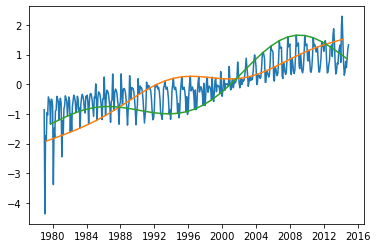

In [17]:
# Checking low pass filtered data (looks weird but fine if you plot each month separately)
plt.plot(era_data.time, era_data['t2m_arc_mean_anom_low_8'])
plt.plot(era_data.time[3:480:12], era_data['t2m_arc_mean_anom_low_8'][3:480:12])
plt.plot(era_data.time[9:480:12], era_data['t2m_arc_mean_anom_low_8'][9:480:12])

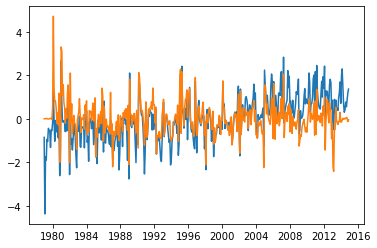

In [37]:
# Checking low pass filtered data
plt.plot(era_data.time, era_data['t2m_arc_mean_anom'])
plt.plot(era_data.time, era_data['t2m_arc_mean_anom_high_8'])

#### sie: 

In [21]:
sat_path ='/glade/scratch/mkbren/cmip6_si_tas/satellite_data/Fetterer_etal_2017/sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/'

for i in np.arange(1,13,1):
    sat_filename = 'N_'+f'{i:02d}' + '_extent_v3.0.csv'
    df1 = pd.read_csv(sat_path+sat_filename)
    if i ==1: 
        df2 = df1
    else: 
        df2 = df2.append(df1)

In [22]:
df = df2.sort_values(['year',' mo'],ascending=True)
df_nonans = df.where(df[' extent']>0)

In [23]:
# Select 1979-2014 (this is 36 complete years of data (other than a couple of nans in the middle))
df_nonans = df_nonans[2:-71]
df_nonans

,year,mo,data-type,region,extent,area
0,1979.0,1.0,Goddard,N,15.41,12.41
0,1979.0,2.0,Goddard,N,16.18,13.18
0,1979.0,3.0,Goddard,N,16.34,13.21
0,1979.0,4.0,Goddard,N,15.45,12.53
0,1979.0,5.0,Goddard,N,13.86,11.11
...,...,...,...,...,...,...
35,2014.0,8.0,Goddard,N,6.08,4.37
35,2014.0,9.0,Goddard,N,5.22,3.74
35,2014.0,10.0,Goddard,N,7.23,5.70
36,2014.0,11.0,Goddard,N,10.11,8.75


In [24]:
# Get sea ice extent time series
sie_1979_2014 = df_nonans[' extent'].values
print(sie_1979_2014.shape)

(432,)


In [25]:
# Fill nans linearly between years to make climatology
sie_1979_2014_fill = np.zeros(len(sie_1979_2014))
for t in range(0, len(sie_1979_2014)): 
    if np.isnan(sie_1979_2014[t]):
        sie_1979_2014_fill[t] = (sie_1979_2014[t+12] + sie_1979_2014[t-12])/2
    else:
        sie_1979_2014_fill[t] = sie_1979_2014[t]

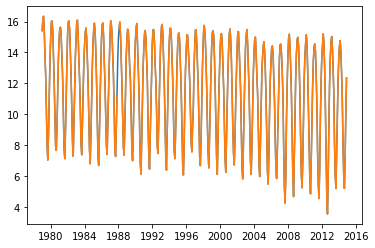

In [39]:
plt.plot(era_data.time, sie_1979_2014_fill)
plt.plot(era_data.time, sie_1979_2014)

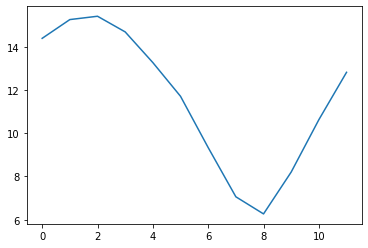

In [27]:
# N.b. climo is the same as calulated by Katie
sie_clim_fill = np.zeros(12)
for m in range(0, 12):
    mo_index = list(range(m, len(sie_1979_2014), 12))
    sie_clim_fill[m] = np.nanmean(sie_1979_2014_fill[mo_index])

plt.plot(sie_clim_fill)

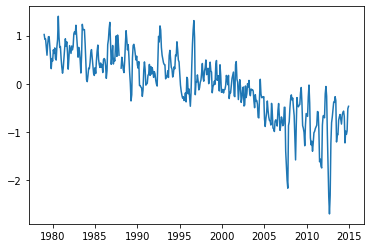

In [28]:
# Getting sea ice extent anomalies for every month
sie_1979_2014_anom = sie_1979_2014 - np.tile(sie_clim_fill, 36)
sie_1979_2014_anom_fill = sie_1979_2014_fill - np.tile(sie_clim_fill, 36) #needed for detrending
plt.plot(df_nonans['year'] + (df_nonans[' mo']-1)/12, sie_1979_2014_anom)

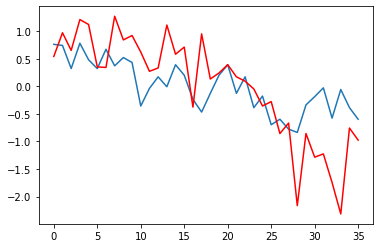

In [29]:
# Checking out march and september anomalies
# Looks like greater trend in sept which is good
plt.plot(sie_1979_2014_anom[list(range(3, 36*12, 12))])
plt.plot(sie_1979_2014_anom[list(range(9, 36*12, 12))], 'r')

In [30]:
era_data['sie_arc_mean_anom'] = xr.DataArray(sie_1979_2014_anom, coords={"time":era_data.time}, dims={'time':era_data.time})
era_data['sie_arc_mean_annual'] = era_data.sie_arc_mean_anom.groupby('time.year').mean()
era_data['sie_arc_mean_annual_anom'] = era_data.sie_arc_mean_annual - era_data.sie_arc_mean_annual.mean(dim='year')

In [31]:
era_data['sie_arc_mean_anom_fill'] = xr.DataArray(sie_1979_2014_anom_fill, coords={"time":era_data.time}, dims={'time':era_data.time})

In [32]:
# Apply 8 year butterworth filter (n.b. using filled in values for filter as can't filter with nans)

era_data['sie_arc_mean_anom_low_8'] = filtfilt_butter_monthly(era_data['sie_arc_mean_anom_fill'],
                                                            filt_year=8, fs=1, order_butter=5,
                                                            ftype='low', dim='time')

era_data['sie_arc_mean_anom_high_8'] = filtfilt_butter_monthly(era_data['sie_arc_mean_anom_fill'],
                                                             filt_year=8, fs=1, order_butter=5,
                                                             ftype='high', dim='time')

era_data['sie_arc_mean_annual_anom_low_8'] = filtfilt_butter(era_data.sie_arc_mean_annual_anom,
                                                           filt_year=8, fs=1, order_butter=5,
                                                           ftype="low", dim='year')

era_data['sie_arc_mean_annual_anom_high_8'] = filtfilt_butter(era_data.sie_arc_mean_annual_anom,
                                                           filt_year=8, fs=1, order_butter=5,
                                                           ftype="high", dim='year')

In [33]:
# Now removing months with filled data
era_data['sie_arc_mean_anom_low_8'][np.isnan(era_data['sie_arc_mean_anom'])] = np.nan
era_data['sie_arc_mean_anom_high_8'][np.isnan(era_data['sie_arc_mean_anom'])] = np.nan

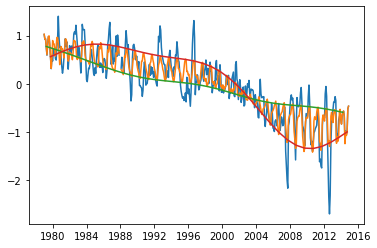

In [41]:
# Checking monthly low pass filtered
plt.plot(era_data.time, era_data['sie_arc_mean_anom'])
plt.plot(era_data.time, era_data['sie_arc_mean_anom_low_8'])
plt.plot(era_data.time[3:480:12], era_data['sie_arc_mean_anom_low_8'][3:480:12])
plt.plot(era_data.time[9:480:12], era_data['sie_arc_mean_anom_low_8'][9:480:12])

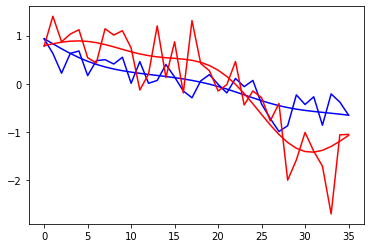

In [45]:
plt.plot(era_data['sie_arc_mean_anom'].sel(time=era_data.time.dt.month==3), 'b')
plt.plot(era_data['sie_arc_mean_anom_low_8'].sel(time=era_data.time.dt.month==3), 'b')
plt.plot(era_data['sie_arc_mean_anom'].sel(time=era_data.time.dt.month==9), 'r')
plt.plot(era_data['sie_arc_mean_anom_low_8'].sel(time=era_data.time.dt.month==9), 'r')

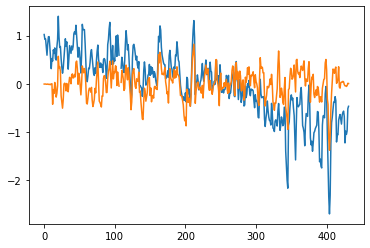

In [36]:
# Check monthly high pass filtered
plt.plot(era_data['sie_arc_mean_anom'])
plt.plot(era_data['sie_arc_mean_anom_high_8'])

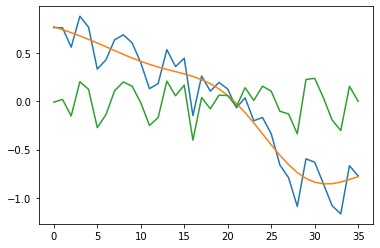

In [47]:
# Annual looking good
plt.plot(era_data['sie_arc_mean_annual_anom'])
plt.plot(era_data['sie_arc_mean_annual_anom_low_8'])
plt.plot(era_data['sie_arc_mean_annual_anom_high_8'])

#### Regress across full time period: 

In [85]:
[slopes_obs, r_obs, intercept_obs] = autils.scatter_linreg(era_data['t2m_arc_mean_anom'],
                                                           era_data['sie_arc_mean_anom'],
                                                           era_data, all_months,
                                                           'obs', plotflag=False)

[slopes_obs_low_8, r_obs_low_8, intercept_obs_low_8] = autils.scatter_linreg(era_data['t2m_arc_mean_anom_low_8'],
                                                                       era_data['sie_arc_mean_anom_low_8'],
                                                                       era_data, all_months,
                                                                       'obs', plotflag=False)

[slopes_obs_high_8, r_obs_high_8, intercept_obs_high_8] = autils.scatter_linreg(era_data['t2m_arc_mean_anom_high_8'],
                                                                          era_data['sie_arc_mean_anom_high_8'],
                                                                          era_data, all_months,
                                                                          'obs', plotflag=False)

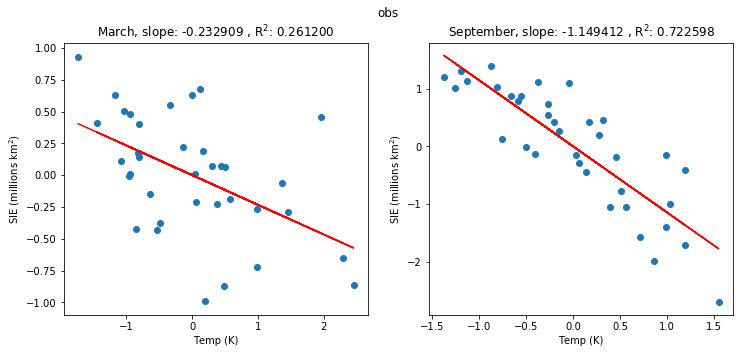

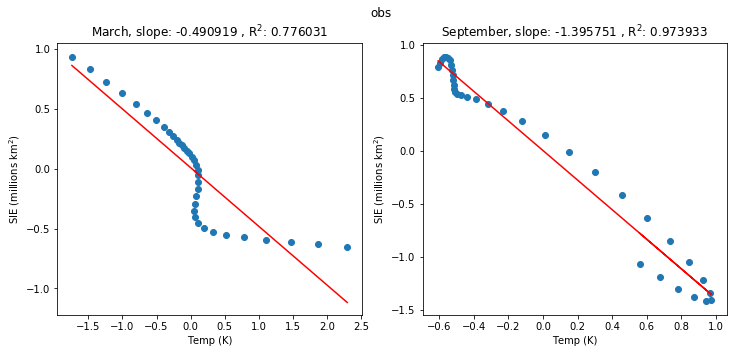

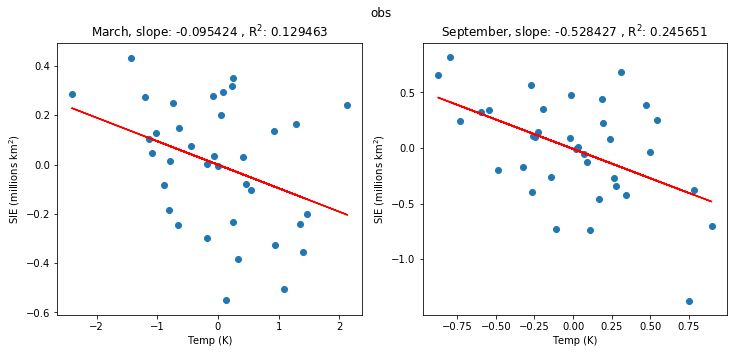

In [86]:
[_, _, _] = autils.scatter_linreg(era_data['t2m_arc_mean_anom'],
                                 era_data['sie_arc_mean_anom'],
                                 era_data, [3, 9],
                                 'obs', plotflag=True)

[_, _, _] = autils.scatter_linreg(era_data['t2m_arc_mean_anom_low_8'],
                                 era_data['sie_arc_mean_anom_low_8'],
                                 era_data, [3, 9],
                                 'obs', plotflag=True)

[_, _, _] = autils.scatter_linreg(era_data['t2m_arc_mean_anom_high_8'],
                                 era_data['sie_arc_mean_anom_high_8'],
                                 era_data, [3, 9],
                                 'obs', plotflag=True)

In [87]:
slope_an, intercept_annual, r_value_annual, _, _ = stats.linregress(era_data.t2m_arc_mean_annual_anom,
                                                                    era_data.sie_arc_mean_annual_anom)
print(slope_an, r_value_annual**2)


slope_an_low_8, intercept_annual_low_8, r_value_annual_low_8, _, _ = stats.linregress(era_data.t2m_arc_mean_annual_anom_low_8,
                                                                    era_data.sie_arc_mean_annual_anom_low_8)
print(slope_an_low_8, r_value_annual_low_8**2)

slope_an_high_8, intercept_annual_high_8, r_value_annual_high_8, _, _ = stats.linregress(era_data.t2m_arc_mean_annual_anom_high_8,
                                                                    era_data.sie_arc_mean_annual_anom_high_8)
print(slope_an_high_8, r_value_annual_high_8**2)

-0.7784098319194179 0.8590667275417979
-0.8304534758085984 0.9819467230476199
-0.29842049473967763 0.43167372245765334


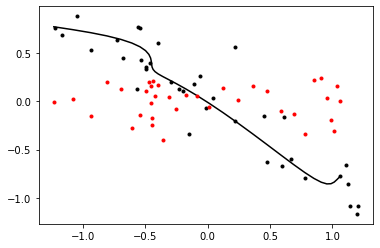

In [98]:
plt.plot(era_data.t2m_arc_mean_annual_anom, era_data.sie_arc_mean_annual_anom, '.k')
plt.plot(era_data.t2m_arc_mean_annual_anom_low_8, era_data.sie_arc_mean_annual_anom_low_8, 'k')
plt.plot(era_data.t2m_arc_mean_annual_anom_low_8, era_data.sie_arc_mean_annual_anom_high_8, '.r')

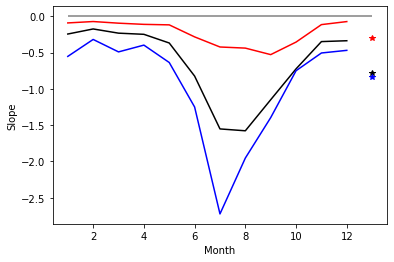

In [114]:
months = list(range(1, 12+1))

plt.hlines(0, 1, 13, 'grey')
plt.plot(months, slopes_obs, 'k')
plt.plot(months, slopes_obs_low_8, 'b')
plt.plot(months, slopes_obs_high_8, 'r')

plt.plot(13, slope_an, '*k')
plt.plot(13, slope_an_low_8, '*b')
plt.plot(13, slope_an_high_8, '*r')

plt.xlabel('Month')
plt.ylabel('Slope');

# Why not shoulder seasons like Katie's?

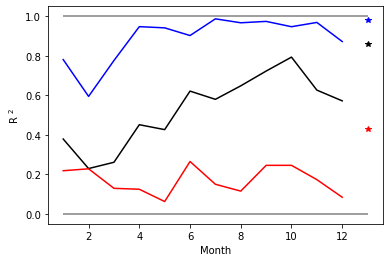

In [112]:
months = np.array(list(range(1, 12+1)))

plt.hlines(0, 1, 13, 'grey')
plt.hlines(1, 1, 13, 'grey')
plt.plot(months, np.array(r_obs) ** 2, 'k')
plt.plot(months, np.array(r_obs_low_8) ** 2, 'b')
plt.plot(months, np.array(r_obs_high_8) ** 2, 'r')

plt.plot(13, np.array(r_value_annual) ** 2, '*k')
plt.plot(13, np.array(r_value_annual_low_8) ** 2, '*b')
plt.plot(13, np.array(r_value_annual_high_8) ** 2, '*r')

plt.xlabel('Month')
plt.ylabel('R $^2$');

## Save reuslts (code not written yet)

In [70]:
#sstr = 'slopes_obs_filt_5_37_years_1979_2014.npz'
#np.savez(sstr,
#         slopes_annual_mean = slopes_annual_mean,
#         slopes_mean = slopes_mean)

# Load results
# meh = np.load(sstr, allow_pickle=True)
# meh.files
# meh['slopes_annual_mean'][()]
# meh['slopes_mm_mean'].shape

In [71]:
#sstr = 'r_obs_windows_5_37_years_1979_2014.npz'
#np.savez(sstr,
#         r_annual_mean = r_annual_mean,
#         r_mean = r_mean)

# Load results
# meh = np.load(sstr, allow_pickle=True)
# meh.files
# meh['r_annual_mean'][()]
# meh['r_mm_mean'].shape